In [52]:
import os
import cv2
import glob
import numpy as np
import imageio
import json
from PIL import Image
from pygifsicle import optimize
import matplotlib.pyplot as plt
%matplotlib inline

from functions import create_sticker_with_info, overlay_image

In [2]:
STATIC_IMAGE_PATH = './Data/vlad_photo.jpeg'
my_image = cv2.imread(STATIC_IMAGE_PATH)[...,::-1]
my_match_info = {
  "away_score": 0,
  "away_team_id": "zenit",
  "away_team_logo": "https://statistics-stat-logos.trbna.com/europe_league/2018-19/zenit.png",
  "away_team_name": "Зенит",
  "home_score": 1,
  "home_team_id": "fc_lokomotiv_moscow",
  "home_team_logo": "https://statistics-stat-logos.trbna.com/champions_league/2018-19/lokomotiv.png",
  "home_team_name": "Локомотив",
  "match_current_time": 90,
  "match_id": 1,
  "match_start_time": 1562950800,
  "venue_capacity": 28800,
  "venue_id": "rzd_arena",
  "venue_lat": 55.65900500000001,
  "venue_lon": 37.560815999999996,
  "venue_name": "РЖД Арена"
}

In [3]:
def alpha_blend(fg, bg, alpha):
    fg = fg.astype("float")
    bg = bg.astype("float")
    alpha = alpha.astype("float") / 255
    fg = cv2.multiply(alpha, fg)
    bg = cv2.multiply(1 - alpha, bg)
    output = cv2.add(fg, bg)
    return output.astype("uint8")

def overlay_image(bg, fg, fgMask, coords):
    (sH, sW) = fg.shape[:2]
    (x, y) = coords
    overlay = np.zeros(bg.shape, dtype="uint8")
    overlay[y:y + sH, x:x + sW] = fg
    alpha = np.zeros(bg.shape[:2], dtype="uint8")
    alpha[y:y + sH, x:x + sW] = fgMask
    alpha = np.dstack([alpha] * 3)
    output = alpha_blend(overlay, bg, alpha)
    return output

def dump_video(filename, clip, fourcc_str='X264', fps=10.0):
    """Write video on disk from a stack of images

    Parameters
    ----------
    filename : str
        Fullpath of video-file to generate
    clip : ndarray
        ndarray where first dimension is used to refer to i-th frame
    fourcc_str : str
        str to retrieve fourcc from opencv
    fps : float
        frame rate of create video-stream

    """
#     fourcc = cv2.cv2.CV_FOURCC(**list(fourcc_str))
    fourcc = cv2.VideoWriter_fourcc(*fourcc_str)
    fid = cv2.VideoWriter(filename, fourcc, fps, np.array(clip[0]).shape[0:2])
    print(fid)
    for i in range(len(clip)):
        fid.write(np.array(clip[i]))

def generate_gifs(image, match_info):
    GIF_FOLDERS = ['woman_red_card', 'goal', '1_0', 'noooo', 'win']#, 'lost']
    SCALE_FACTORS = {'woman_red_card': (2, 2), 'goal': (1, 1), '1_0': (5, 5), 
                     'noooo': (2, 2), 'win': (2, 2)}#, 'lost': (2, 2)}
    COORDS = {'woman_red_card': (0.6, 0.8), 'goal': (0, 0.3), '1_0': (0.1, 0.85), 
              'noooo': (0, 0.8), 'win': (0,0.75)}#, 'lost': (0,0.7)}
    NUM_FRAMES = {'woman_red_card': 45, 'goal': 24, '1_0': 10, 
                  'noooo': 8, 'win': 2}#, 'lost': 2}
    DURATION = {'woman_red_card': 50, 'goal': 100, '1_0': 150, 
                'noooo': 100, 'win': 100}#, 'lost': 100}
    
    static_image = cv2.resize(image, dsize=(480, 640))

    for i, gif_name in enumerate(GIF_FOLDERS):
        if gif_name == 'win' or gif_name == 'noooo':
            versus_sticker = create_sticker_with_info(match_info=match_info)
            versus_img = versus_sticker[:,:,:3]
            versus_img_mask = versus_sticker[:,:,3]
            static_image = overlay_image(
                bg=static_image, 
                fg=versus_img, 
                fgMask=versus_img_mask, 
                coords=(
                    static_image.shape[1]//4,
                    20
                )
            )
        gif = []
        for img_name in sorted(glob.glob(f'./Data/{gif_name}/frame_*.gif')):
            curr_frame = imageio.mimread(img_name)[0]
            gif.append(
                cv2.resize(
                    curr_frame, 
                    dsize=(
                        curr_frame.shape[1]//SCALE_FACTORS[gif_name][0], 
                        curr_frame.shape[0]//SCALE_FACTORS[gif_name][1])
                )
            ) 
        gif_array = []
        for idx, gif_frame in enumerate(gif):
            gif_img = gif_frame[:,:,:3]
            gif_img_mask = gif_frame[:,:,3]
            overlayed_img = overlay_image(
                bg=static_image, 
                fg=gif_img, 
                fgMask=gif_img_mask, 
                coords=(
                    int(static_image.shape[1]*COORDS[gif_name][0]),
                    int(static_image.shape[1]*COORDS[gif_name][1])
                )
            )
            gif_array.append(Image.fromarray(overlayed_img))
#         out_gif_name = './static/gifs/'+STATIC_IMAGE_PATH.split('/')[-1].split('.')[0]+'_'+gif_name+'.gif'
        # GIF version
        gif_array[0].save(
            f'./static/gifs/{i}.gif', 
            save_all=True, 
            append_images=gif_array[:NUM_FRAMES[gif_name]], 
            duration=DURATION[gif_name], 
            loop=0
        )
        optimize(f'./static/gifs/{i}.gif')
        # VIDEO version
        dump_video(
            filename=f'./static/gifs/{i}.mp4',
            clip=gif_array
        )

In [12]:
%%time
generate_gifs(my_image, my_match_info)

<VideoWriter 0x7f976a3cb390>
<VideoWriter 0x7f976a3cb6b0>
<VideoWriter 0x7f976c8cda90>
<VideoWriter 0x7f976a3cb9f0>
<VideoWriter 0x7f976a3cb510>
CPU times: user 13.8 s, sys: 1.42 s, total: 15.2 s
Wall time: 6.79 s


### Put text:

In [39]:
STATIC_IMAGE_PATH = './Data/vlad_photo.jpeg'
my_image = cv2.imread(STATIC_IMAGE_PATH)[...,::-1]

In [461]:
# new_image = cv2.putText(
#     my_image, 
#     text='Congratulartions!', 
#     org=(my_image.shape[1]//2, my_image[0]//2),
# )
# plt.imshow(new_image)
# plt.show();

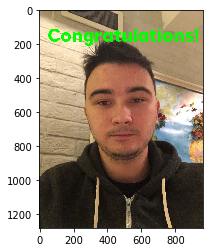

In [464]:
from PIL import ImageFont, Image, ImageDraw

fontpath = "./Data/Grey Sans Bold.ttf"     
font = ImageFont.truetype(fontpath, 100)
img_pil = Image.fromarray(my_image)
draw = ImageDraw.Draw(img_pil)
b,g,r,a = 0,255,0,0
draw.text((50, 100),  "Congratulations!", font=font, fill=(b,g,r,a))
plt.imshow(img_pil)
plt.show()

In [478]:
from PIL import ImageFont, Image, ImageDraw

fontpath = "./Data/Grey Sans Bold.ttf"     
font = ImageFont.truetype(fontpath, 100)
img_cv2 = cv2.putText(img=my_image, text="Congratulations!", org=(50, 100), fontFace=font, fontscale=(255,0,0,0))
plt.imshow(img_cv2)
plt.show()

TypeError: an integer is required (got type FreeTypeFont)

### Gradient:

In [1]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),10))

In [2]:
colors

[<Color red>,
 <Color #f13600>,
 <Color #e36500>,
 <Color #d58e00>,
 <Color #c7b000>,
 <Color #a4b800>,
 <Color #72aa00>,
 <Color #459c00>,
 <Color #208e00>,
 <Color green>]

In [14]:
teams_info_file = './Data/teams_info.json'
with open(teams_info_file, 'r') as file:
    teams_info = json.load(file)

In [21]:
one_key = list(teams_info.keys())[0]
teams_info

{'локомотив': {'id': 'fc_lokomotiv_moscow',
  'name': 'Локомотив',
  'colors': [{'first': '#018240', 'second': '#CF1E26'}],
  'logo': {'main': 'https://statistics-stat-logos.trbna.com/champions_league/2018-19/lokomotiv.png'}},
 'арсенал тула': {'id': 'arsenal_tula',
  'name': 'Арсенал Тула',
  'colors': [{'first': '#ca040a', 'second': '#FFD301'}],
  'logo': {'main': 'https://s5o.ru/storage/simple/ru/edt/19/34/88/94/rueeed52fad02.jpeg'}},
 'урал екатеринбург': {'id': 'fc_ural_yekaterinburg',
  'name': 'Урал Екатеринбург',
  'colors': [{'first': '#eb6120', 'second': '#000000'}],
  'logo': {'main': 'https://s5o.ru/storage/simple/ru/edt/11/49/70/31/rue7b0ad0aef4.jpeg'}},
 'спартак': {'id': 'spartak_moscow',
  'name': 'Спартак',
  'colors': [{'first': '#d50000', 'second': '#660000'}],
  'logo': {'main': 'https://s5o.ru/storage/simple/ru/edt/20/36/94/18/rue2997571681.jpeg'}},
 'ростов': {'id': 'fc_rostov',
  'name': 'Ростов',
  'colors': [{'first': '#FBE903', 'second': '#254694'}],
  'logo':

In [44]:
from PIL import ImageFont, Image, ImageDraw

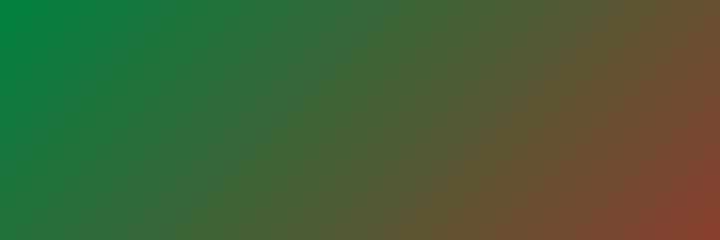

In [45]:
gradient

* Generate gradient:

In [208]:
def interpolate(f_co, t_co, interval):
        det_co =[(t - f) / interval for f , t in zip(f_co, t_co)]
        for i in range(interval):
            yield [round(f + det * i) for f, det in zip(f_co, det_co)]

def return_gradient(teams_info, team_name):
    h1 = teams_info[team_name]['colors'][0]['first'].lstrip('#')
    h2 = teams_info[team_name]['colors'][0]['second'].lstrip('#')
    rgb1 = tuple(int(h1[i:i+2], 16) for i in (0, 2, 4))
    rgb2 = tuple(int(h2[i:i+2], 16) for i in (0, 2, 4))
    gradient = Image.new('RGBA', (720, 400), color=0)
    draw = ImageDraw.Draw(gradient)
    for i, color in enumerate(interpolate(rgb1, rgb2, 720 * 2)):
        draw.line([(i, 0), (0, i)], tuple(color), width=1)
    gradient = np.array(gradient)
    logo_img = imageio.imread(teams_info[team_name]['logo']['main'])
    scale = gradient.shape[0] / logo_img.shape[1]
    logo_img = cv2.resize(
        logo_img, dsize=(int(logo_img.shape[1]*scale), int(logo_img.shape[0]*scale))
    )
    center_x = gradient.shape[1]//2-logo_img.shape[1]//2
    if logo_img.shape[2] == 3:
        logo_alpha = np.ones((logo_img.shape[0], logo_img.shape[1], 4))*255
        logo_alpha[...,:3] = logo_img
        logo_img = logo_alpha
    grad_with_logo = overlay_image(
        bg=gradient[...,:3], fg=logo_img[...,:3], fgMask=logo_img[...,3], coords=(center_x, 0)
    )
    team_id = teams_info[team_name]['id']
    team_name = curr_team_name.replace(' ', '_')
    cv2.imwrite(f'./static/grads/{team_id}.jpg', grad_with_logo[...,::-1])
    return f'http://95.213.37.132:5000/static/grads/{team_id}.jpg'

http://95.213.37.132:5000/static/grads/fc_lokomotiv_moscow.jpg
http://95.213.37.132:5000/static/grads/arsenal_tula.jpg
http://95.213.37.132:5000/static/grads/fc_ural_yekaterinburg.jpg
http://95.213.37.132:5000/static/grads/spartak_moscow.jpg
http://95.213.37.132:5000/static/grads/fc_rostov.jpg
http://95.213.37.132:5000/static/grads/fc_kryliya_sovetov_samara.jpg
http://95.213.37.132:5000/static/grads/zenit.jpg
http://95.213.37.132:5000/static/grads/fc_akhmat_grozny.jpg
http://95.213.37.132:5000/static/grads/fc_ufa.jpg
http://95.213.37.132:5000/static/grads/cska_moscow.jpg
http://95.213.37.132:5000/static/grads/fc_dinamo_moscow.jpg
http://95.213.37.132:5000/static/grads/dinamo_st_pburg.jpg
http://95.213.37.132:5000/static/grads/fk_tambov.jpg
http://95.213.37.132:5000/static/grads/fc_krasnodar.jpg
http://95.213.37.132:5000/static/grads/fc_orenburg.jpg
http://95.213.37.132:5000/static/grads/fc_rubin_kazan.jpg


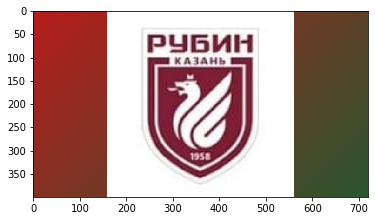

In [209]:
for curr_team_name in teams_info:
    grad_img_path = return_gradient(teams_info, team_name=curr_team_name)
    print(grad_img_path)
    team_id = teams_info[curr_team_name]['id']
    plt.imshow(cv2.imread(f'./static/grads/{team_id}.jpg')[...,::-1]);

* Generate feed info:

In [145]:
import pandas as pd
MATCHES_INFO_PATH = './Data/matches_info.csv'
matches_info = pd.read_csv(
    MATCHES_INFO_PATH
)
matches_info

,Unnamed: 0,match_id,match_start_time,home_team_id,home_team_name,home_team_logo,away_team_id,away_team_name,away_team_logo,home_score,away_score,venue_id,venue_name,venue_capacity,venue_lon,venue_lat
0,0,1,1562950800,fc_lokomotiv_moscow,Локомотив,https://statistics-stat-logos.trbna.com/champi...,zenit,Зенит,https://statistics-stat-logos.trbna.com/europe...,1,0,rzd_arena,РЖД Арена,28800.0,37.560816,55.659005
1,1,18382061,1562950800,arsenal_tula,Арсенал Тула,https://s5o.ru/storage/simple/ru/edt/19/34/88/...,fc_dinamo_moscow,Динамо,https://s5o.ru/storage/simple/ru/edt/16/ab/10/...,1,1,arsenal_stadium,Арсенал,20074.0,37.603056,54.174167
2,2,18382065,1563024600,fc_ural_yekaterinburg,Урал Екатеринбург,https://s5o.ru/storage/simple/ru/edt/11/49/70/...,fc_ufa,Уфа,https://s5o.ru/storage/simple/ru/edt/85/49/70/...,3,2,ekaterinburg_arena,Central Stadium,35061.0,60.573611,56.832500
3,3,18382053,1563033600,spartak_moscow,Спартак,https://s5o.ru/storage/simple/ru/edt/20/36/94/...,dinamo_st_pburg,Сочи,https://s5o.ru/storage/simple/ru/edt/45/f3/da/...,1,0,otkritie_arena,Открытие Арена,44360.0,37.440250,55.817861
4,4,18382055,1563042600,fc_rostov,Ростов,https://s5o.ru/storage/simple/ru/edt/06/36/53/...,fc_orenburg,Оренбург,https://s5o.ru/storage/simple/ru/edt/27/22/66/...,2,1,rostov_arena,Ростов Арена,45000.0,39.737778,47.209444
5,5,18382063,1563111000,fc_kryliya_sovetov_samara,Крылья Советов,https://s5o.ru/storage/simple/ru/edt/64/22/33/...,cska_moscow,ЦСКА,https://statistics-stat-logos.trbna.com/champi...,2,0,samara_arena,Самара Арена,44918.0,50.237222,53.277778
6,6,18382051,1563120000,zenit,Зенит,https://statistics-stat-logos.trbna.com/europe...,fk_tambov,ФК Тамбов,https://s5o.ru/storage/simple/ru/edt/bb/cb/49/...,2,1,saint_petersburg_stadium,Стадион Санкт-Петербург,70000.0,30.220533,59.972953
7,7,18382059,1563129000,fc_akhmat_grozny,Ахмат,https://s5o.ru/storage/simple/ru/edt/eb/e9/7c/...,fc_krasnodar,Краснодар,https://statistics-stat-logos.trbna.com/europe...,1,0,akhmat-arena,Ахмат-Арена,30597.0,45.745252,43.323176
8,8,18382057,1563210000,fc_lokomotiv_moscow,Локомотив,https://statistics-stat-logos.trbna.com/champi...,fc_rubin_kazan,Рубин Казань,https://s5o.ru/storage/simple/ru/edt/10/85/3e/...,1,1,rzd_arena,РЖД Арена,28800.0,37.741111,55.803611
9,9,18382079,1563620400,fc_ufa,Уфа,https://s5o.ru/storage/simple/ru/edt/85/49/70/...,fc_krasnodar,Краснодар,https://statistics-stat-logos.trbna.com/europe...,2,3,neftyanik_stadium,Нефтяник,15234.0,56.061450,54.825864


In [204]:
def return_feed_info(teams_info, matches_info, team_name):
    grad_with_logo_link = return_gradient(teams_info, team_name)
    team_id = teams_info[team_name]['id']
    print(team_id)
    team_matches = matches_info[
        (matches_info['home_team_id'] == team_id) | (matches_info['away_team_id'] == team_id)
    ]
    team_matches = team_matches[
        (team_matches['home_score'] != 0) & (matches_info['away_score'] != 0)
    ]
    team_matches.sort_values('match_start_time', ascending=False, inplace=True)
    matches_for_feed = team_matches.iloc[:2, :]
    print(matches_for_feed)
    result_list = []
    for row_match in matches_for_feed.iterrows():
        score_comment = ''
        match = row_match[1]
        if team_id == match['home_team_id']:
            won = match['home_score'] > match['away_score']
            draw = match['home_score'] == match['away_score']
        elif team_id == match['away_team_id']:
            won = match['away_score'] > match['home_score']
            draw = match['away_score'] == match['home_score']
        score_comment = 'Победа!' if won else ('Ничья!' if draw else 'Проигрыш.')
        score_comment += f' Финальный счет: {match["home_score"]} -- {match["away_score"]}'
        score_comment += ' 🎉' if won else (' 😕' if draw else ' 😔')
        show_home_name = match["home_team_name"].split(' ')[0]
        show_away_name = match["away_team_name"].split(' ')[0]
        result_list.append([
            f'{show_home_name} -- {show_away_name}',
            score_comment
        ])
    return result_list
# {
#   "colors": [
#     {
#       "first": "#2196f3",
#       "second": "#081630"
#     }
#   ],
#   "id": "zenit",
#   "logo": {
#     "main": "https://statistics-stat-logos.trbna.com/europe_league/2018-19/zenit.png"
#   },
#   "name": "Зенит",
#   "screen_3_logo": "http://95.213.37.132:5000/static/grads/зенит.jpg",
#   "screen_3_text": [
#     [
#       "team1 — team2",
#       "Победа! Финальный счет: 2 - 1 :)"
#     ],
#     [
#       "team1 — team2",
#       "Победа! Финальный счет: 2 - 1 :)"
#     ]
#   ]
# }

In [205]:
res = return_feed_info(
    teams_info=teams_info, 
    matches_info=matches_info, 
    team_name='локомотив'
)

fc_lokomotiv_moscow


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


    Unnamed: 0  match_id  match_start_time         home_team_id  \
72          77  18382209        1569141000          fc_orenburg   
56          60  18382165        1567258200  fc_lokomotiv_moscow   

   home_team_name                                     home_team_logo  \
72       Оренбург  https://s5o.ru/storage/simple/ru/edt/27/22/66/...   
56      Локомотив  https://statistics-stat-logos.trbna.com/champi...   

           away_team_id away_team_name  \
72  fc_lokomotiv_moscow      Локомотив   
56            fc_rostov         Ростов   

                                       away_team_logo  home_score  away_score  \
72  https://statistics-stat-logos.trbna.com/champi...           2           3   
56  https://s5o.ru/storage/simple/ru/edt/06/36/53/...           1           2   

           venue_id venue_name  venue_capacity  venue_lon  venue_lat  
72  gazovik_stadium    Газовик          4950.0  55.219000  51.787754  
56        rzd_arena  РЖД Арена         28800.0  37.741111  55.803611

In [206]:
res

[['Оренбург -- Локомотив', 'Победа! Финальный счет: 2 -- 3 🎉'],
 ['Локомотив -- Ростов', 'Проигрыш. Финальный счет: 1 -- 2 😔']]

In [164]:
ALREADY_GENERATED_GRADS = [x.split('.')[0] for x in os.listdir('./static/grads/')]
ALREADY_GENERATED_GRADS

['рубин_казань',
 'краснодар',
 'локомотив',
 'зенит',
 'ахмат',
 'динамо',
 'спартак',
 'ростов',
 'оренбург',
 'сочи',
 '',
 'фк_тамбов',
 'арсенал_тула',
 'урал_екатеринбург',
 'уфа',
 'цска',
 'крылья_советов']

In [38]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import numpy as np

# def colorFader(c1,c2,mix=0): # fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
#     c1=np.array(mpl.colors.to_rgb(c1))
#     c2=np.array(mpl.colors.to_rgb(c2))
#     return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# c1 = teams_info[one_key]['colors'][0]['first']
# c2 = teams_info[one_key]['colors'][0]['second']
# n = 500

# fig, ax = plt.subplots()
# for x in range(n+1):
#     ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4) 
# plt.show();

In [37]:
# data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
# print(data.shape)
# data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# data.shape